# Prepare
## Dataset loading

In [147]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm
from scipy.interpolate import interp1d
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt


train_raw = pd.read_excel('/home/competition/data/data/ai_competition_train.xlsx')
test_raw = pd.read_excel('/home/competition/data/data/ai_competition_test.xlsx')

train = np.array(train_raw['flux'])
test = np.array(test_raw['flux'])

print(train.shape, test.shape)

#windows shift
INPUT_DAYS = 60


(5479,) (60,)


### NaN to zeros

In [148]:
def nan_to_zero(_input):        
    print("1. NaNtoZero; NaN 값의 개수:", np.sum(np.isnan(_input)), "개는 0으로 대체되었음.")
    nan_indices = np.isnan(train)
    _mask = np.zeros(len(train))
    _input[nan_indices] = _mask[nan_indices]
    return _input, nan_indices


### Cut zeros

In [149]:
def cut_zeros(_data):
    print("2. Before cut zeros: ", _data.shape)
    _data_cut = _data[_data != 0]
    print("3. After cut zeros: ", _data_cut.shape)
    return _data_cut

### Make dataset windows shift

In [150]:
def make_dataset_windowsshift(_input, window_size=INPUT_DAYS):
    #assert min(_input) > 0
    # subtract mean
    _data = _input.copy()
    
    _data_submean = _data - np.mean(_data)
    
    train_x = np.zeros([INPUT_DAYS, 1])
    train_y = np.zeros([1, 1])

    #print("x and y shape :", train_x.shape, train_y.shape)
    for i in range(len(_data_submean) - INPUT_DAYS - 1):
        train_x = np.concatenate(
            (train_x, _data_submean[i:i+INPUT_DAYS, np.newaxis]), axis=1)
        train_y = np.concatenate(
            (train_y, _data_submean[np.newaxis, i+INPUT_DAYS+1, np.newaxis]), axis=1)

    #print("x and y shape :", train_x.shape, train_y.shape)
    train_x = train_x[:, 1:]
    train_y = train_y[:, 1:]
    train_x = train_x.T
    train_y = train_y.T
    print("4. Dataset shape : ", train_x.shape, train_y.shape)
    
    return train_x, train_y


### linear interpolation and replace

In [151]:
# def linear_interpolation_with_replace(_input, _original, _nan_idx):
    
#     interp_func = interp1d(np.arange(len(_input)), _input, kind='linear')
#     # 보간된 데이터 생성
#     data_5479 = interp_func(np.linspace(0, len(_input) - 1, len(_original)))

#     # 원본 배열 (5479,) - NaN 값이 포함된 배열 (예시로 임의의 데이터 사용)
#     interpolated = _original.copy()

#     # NaN 위치에 A의 동일 인덱스 값 대입
#     interpolated[_nan_idx] = data_5479[_nan_idx]
#     print("4. interpolation shape : ", train_intered.shape)
#     return interpolated

### kalman smoothing

In [152]:
def kalman_filter(observations, initial_estimate, initial_error, process_noise, measurement_noise):
    n = len(observations)
    estimations = np.zeros(n)
    errors = np.zeros(n)

    estimate = initial_estimate
    error = initial_error

    for i in range(n):
        # Prediction Step
        estimate = estimate  # In a simple model, prediction equals the previous estimate
        error = error + process_noise  # Add process noise

        # Update Step
        kalman_gain = error / (error + measurement_noise)
        estimate = estimate + kalman_gain * (observations[i] - estimate)
        error = (1 - kalman_gain) * error

        estimations[i] = estimate
        errors[i] = error

    return estimations, errors

In [153]:
def apply_kalman_smoothing(_input):
    
    ######################################################
    observations = _input.copy()
    # 초기 추정값 및 오차 공분산 행렬
    initial_estimate = train_cut[0]
    initial_error = 1.0
    # 프로세스 노이즈(process_noise)와 측정 노이즈(measurement_noise)의 값의 범위는 주로 사용되는 시스템 및 센서의 특성에 따라 달라질 수 있습니다. 그러나 일반적으로 다음과 같은 범위를 사용하는 것이 흔합니다:

    # 프로세스 노이즈 (process_noise):

    # 보통 0과 1 사이의 값을 가집니다. 이 범위 내에서 값을 조정하면, 시스템의 예측이 얼마나 불확실한지를 조절할 수 있습니다.
    # 값이 0에 가까울수록 예측이 더 안정적이고, 값이 1에 가까워질수록 예측이 불안정해질 수 있습니다.
    # 측정 노이즈 (measurement_noise):

    # 일반적으로 1 이상의 양수 값을 가집니다. 이 값은 관측값의 정확성을 나타냅니다.
    # 값이 클수록 관측값에 대한 노이즈가 크며, 값이 작을수록 관측값이 정확합니다.
    # 시스템 모델의 프로세스 노이즈 및 측정 노이즈 설정
    process_noise = 0.9
    measurement_noise = 1.0

    # 칼만 스무딩 수행
    estimations, errors = kalman_filter(observations, initial_estimate, initial_error, process_noise, measurement_noise)

    ######################################################
    return estimations

1. NaNtoZero; NaN 값의 개수: 1251 개는 0으로 대체되었음.
2. Before cut zeros:  (5479,)
3. After cut zeros:  (4228,)
4. Dataset shape :  (4167, 60) (4167, 1)


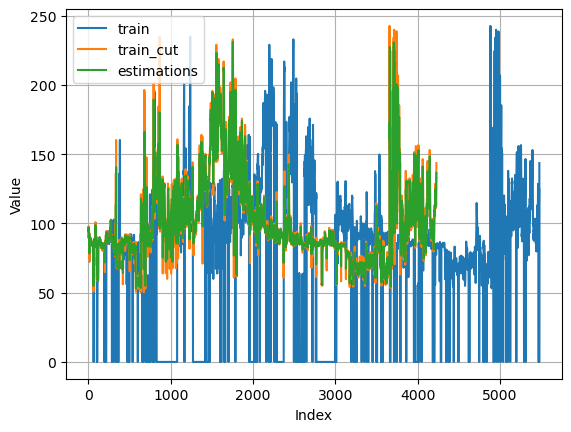

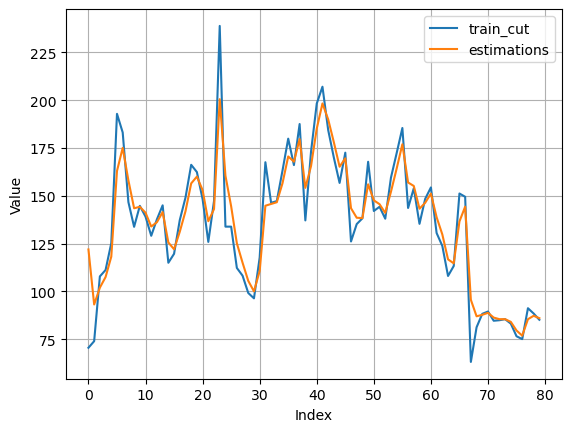

In [154]:
train = np.array(train_raw['flux'])

train_zeros, _nan_idx = nan_to_zero(train)
train_cut = cut_zeros(train_zeros)
kalman_estimations = apply_kalman_smoothing(train_cut)


# without kalman
#train_x, train_y = make_dataset_windowsshift(train_cut)
# with kalman
train_x, train_y = make_dataset_windowsshift(kalman_estimations)


plt.figure()
plt.plot(train, label='train')
plt.plot(train_cut, label='train_cut')
plt.plot(kalman_estimations, label='estimations')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_cut[3720:3800], label='train_cut')
#plt.plot(train, label='train')
plt.plot(kalman_estimations[3720:3800], label='estimations')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

---

# Model

### Define model

In [155]:
loss_history = []


class LossHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_history.append(logs['loss'])


loss_callback = LossHistory()


# RMSE 손실 함수 정의
def rmse_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=-1))


# some papers model
def create_lstm_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=128, input_shape=input_shape, return_sequences=True))  # 첫 번째 LSTM 레이어
    model.add(keras.layers.Dropout(rate=0.2))  # 드롭아웃
    model.add(keras.layers.LSTM(units=128, return_sequences=False))  # 두 번째 LSTM 레이어
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(1))
    #model.compile(optimizer='adam', loss=rmse_loss)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])
    return model

## First training

In [156]:
input_shape = (INPUT_DAYS, 1)
first_lstm_model = create_lstm_model(input_shape)
first_lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 128)           66560     
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_15 (LSTM)              (None, 128)               131584    
                                                                 
 dense_31 (Dense)            (None, 256)               33024     
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dense_33 (Dense)            (None, 1)                 129       
                                                                 
Total params: 264193 (1.01 MB)
Trainable params: 2641

In [157]:
start_time = time.time()
first_lstm_model.fit(train_x, train_y, epochs=50, batch_size=128, callbacks=[loss_callback])
print(f"코드 실행 시간: {time.time()-start_time} 초")


Epoch 1/50
33/33 [==============================] - 9s 143ms/step - loss: 477.7459 - root_mean_squared_error: 21.8574
Epoch 2/50
33/33 [==============================] - 5s 141ms/step - loss: 133.9658 - root_mean_squared_error: 11.5744
Epoch 3/50
33/33 [==============================] - 5s 139ms/step - loss: 100.2124 - root_mean_squared_error: 10.0106
Epoch 4/50
33/33 [==============================] - 5s 141ms/step - loss: 93.8224 - root_mean_squared_error: 9.6862
Epoch 5/50
33/33 [==============================] - 5s 141ms/step - loss: 89.9052 - root_mean_squared_error: 9.4818
Epoch 6/50
33/33 [==============================] - 5s 141ms/step - loss: 88.7598 - root_mean_squared_error: 9.4212
Epoch 7/50
33/33 [==============================] - 5s 141ms/step - loss: 86.4486 - root_mean_squared_error: 9.2978
Epoch 8/50
33/33 [==============================] - 5s 143ms/step - loss: 84.3164 - root_mean_squared_error: 9.1824
Epoch 9/50
33/33 [==============================] - 5s 143ms/step 

KeyboardInterrupt: 

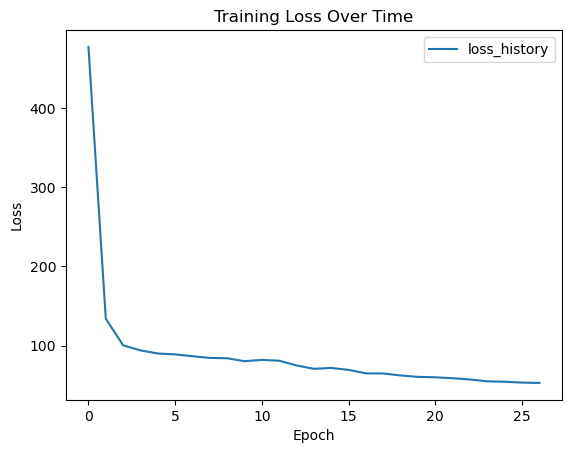

In [158]:
plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.legend(['loss_history', 'rmse_history'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# Prediction

---

In [159]:
def prediction(_input, _model):
    _copy = _input.copy()

    # 아무런 전처리 필요없음.

    _copy_mean = np.mean(_copy)
    _result = _copy - _copy_mean

    # sub mean은 학습할때만 해주면 됨.
    # training시의 sub mean은 make dataset에서 해줌.

    for i in tqdm(range(30)):
        _output = _model.predict(
            _result[np.newaxis, i:i+INPUT_DAYS, np.newaxis], verbose=0)
        _result = np.concatenate((_result, _output[0]), axis=0)

    # Subtract mean했던거 다시 더해주기
    _result = _result + _copy_mean
    _summit = _result[-30:]

    plt.figure()
    plt.plot(_result, label='output')
    plt.plot(test, label='input')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    return _summit


- input 60개로 61번째 예측
- 2번째 ~ 61번째로, 62번째 예측
- 90번째를 예측할 때 까지 반복하고, 61~90번째를 제출

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:02<00:00, 14.09it/s]


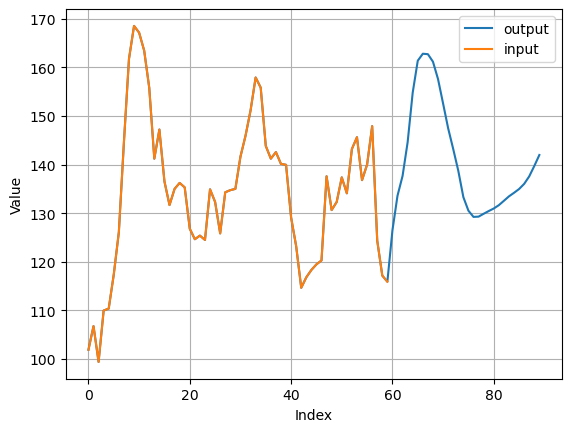

100%|██████████| 30/30 [00:01<00:00, 22.48it/s]


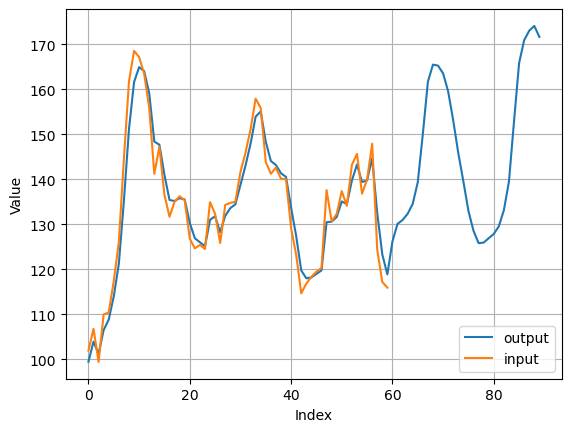

In [160]:
_final_result = prediction(test, first_lstm_model)

kalman_estimations = apply_kalman_smoothing(test)
_final_result = prediction(kalman_estimations, first_lstm_model)

## output xlsx file 생성

In [161]:
import datetime

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
df = pd.DataFrame({'date': np.array(range(1, 31)), 'flux': _final_result})

# DataFrame을 엑셀 파일로 내보내기
file_name = f'/home/competition/data/data/dev/{current_time}_output_{loss_history[-1]}.xlsx'
df.to_excel(file_name, index=False)

model_name = f'/home/competition/data/data/dev/{current_time}_model_{loss_history[-1]}.h5'
first_lstm_model.save(model_name)


/home/competition/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 기존 6.85 모델이랑 비교

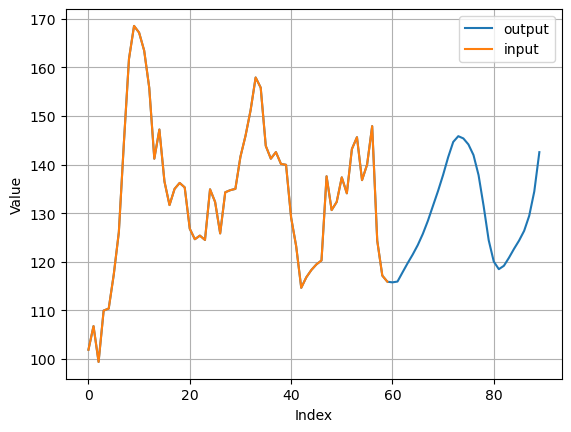